# Pipeline de Machine Learning pour la Prédiction de Pannes - Helpdesk SNRT

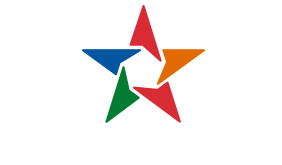

## Objectif du Projet
Ce notebook présente un pipeline complet de Machine Learning visant à prédire le moment probable de défaillance d’un équipement. Il répondra aux questions:
- Quand cet équipement va-t-il tomber en panne ? Dans combien de jours exactement ?
- Quelle est la probabilité de panne dans les 7/30/90 prochains jours ?

## Modèles utilisés :
- **Régression** : prédire un nombre de jours restant avant la panne.
- **Analyse de survie** : estimer la probabilité qu’un équipement tombe en panne dans un intervalle donné.
- **Séries temporelles** : modélisation spécifique pour chaque équipement.


## Plan du Notebook
01. **Configuration & Métadonnées** - Setup du projet
02. **Imports & Environnement** - Librairies et configuration
03. **Fonctions Utilitaires** - Classes et outils réutilisables
04. **Chargement & Exploration** - Import et analyse initiale
05. **Analyse Exploratoire** - Visualisations et statistiques
06. **Nettoyage & Préparation** - Traitement des données
07. **Feature Engineering** - Création de variables temporelles
08. **Préparation Features** - Encodage et normalisation
09. **Sélection Modèles** - Validation croisée temporelle
10. **Optimisation Hyperparamètres** - Tuning du meilleur modèle
11. **Entraînement Final** - Modèle calibré avec métriques
12. **Analyse Features** - Importance et corrélations
13. **Visualisations Avancées** - Graphiques de performance
14. **Fonction Prédiction** - Classe pour production
15. **Tableau de Bord** - Interface maintenance prédictive
16. **Sauvegarde & Déploiement** - Export et documentation
17. **Résumé Exécutif** - Métriques business et recommandations

### Cellule 1: Configuration et Métadonnées

In [1]:
from datetime import datetime
import warnings
import sys
import os

# Suppression des avertissements
warnings.filterwarnings('ignore')

# Configuration du projet
PROJECT_CONFIG = {
    'Nom du projet': 'Maintenance Prédictive SNRT',
    'Environnement': 'Google Colab',
    'Version': '1.0',
    'Auteur': 'Aymane ISSAMI',
    'Date d\'exécution': datetime.now().strftime('%Y-%m-%d'),
    'Objectif': "Prédire le temps jusqu'à la prochaine panne d'équipement"
}

print("LANCEMENT DU PIPELINE DE MAINTENANCE PRÉDICTIVE")
print("=" * 65)
for key, value in PROJECT_CONFIG.items():
    print(f"{key}: {value}")
print("=" * 65)

LANCEMENT DU PIPELINE DE MAINTENANCE PRÉDICTIVE
Nom du projet: Maintenance Prédictive SNRT
Environnement: Google Colab
Version: 1.0
Auteur: Aymane ISSAMI
Date d'exécution: 2025-08-04
Objectif: Prédire le temps jusqu'à la prochaine panne d'équipement


### Cellule 2: Imports et Librairies

In [2]:
# Configuration et imports robustes pour l'analyse prédictive de maintenance
import warnings
warnings.filterwarnings('ignore')

# Imports de base
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

print("Configuration de base chargée avec succès!")

Configuration de base chargée avec succès!


### Cellule 3: Chargement des Données

In [3]:
# Montage Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Chargement des données...")
try:
    df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/data/Data_Helpdesk_New_From_ITSM.xlsx')
    print(f"Dataset chargé: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
except Exception as e:
    print(f"Erreur lors du chargement: {e}")
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_excel(list(uploaded.keys())[0])

# Affichage de la structure
print("\nColonnes disponibles:")
for col in df.columns:
    print(f"   - {col}")

print(f"\nAperçu des données:")
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Chargement des données...
Dataset chargé: 46,495 lignes × 7 colonnes

Colonnes disponibles:
   - CodeIntervention
   - TypeIntervention
   - DescriptionInterv
   - code_equipement
   - equipement
   - statut
   - DateDebut

Aperçu des données:
  CodeIntervention TypeIntervention  \
0      ITIM0000004         incident   
1      ITIM0000005         incident   
2      ITIM0000006     demande_info   
3      ITIM0000011         incident   
4      ITIM0000012         incident   

                                   DescriptionInterv code_equipement  \
0                 Intervention: incident - KM0000553       SUB000508   
1                 Intervention: incident - KM0000611       WBA000124   
2  Intervention: request for information - KM0000339       DTA000024   
3                 Intervention: incident - KM0000611       WBA000124   
4                 Intervention: 

### Cellule 4 : Préparation Temporelle des Données

In [4]:
print("PRÉPARATION TEMPORELLE DES DONNÉES")
print("=" * 50)

# Conversion de la colonne date
df['DateDebut'] = pd.to_datetime(df['DateDebut'], errors='coerce')

# Supprimer les lignes sans date
df_clean = df.dropna(subset=['DateDebut']).copy()
print(f"Lignes avec dates valides: {len(df_clean):,}")

# Trier par équipement et date
df_clean = df_clean.sort_values(['code_equipement', 'DateDebut'])

# Analyse temporelle
print(f"\nPériode couverte:")
print(f"   Du: {df_clean['DateDebut'].min()}")
print(f"   Au: {df_clean['DateDebut'].max()}")
print(f"   Durée: {(df_clean['DateDebut'].max() - df_clean['DateDebut'].min()).days} jours")

PRÉPARATION TEMPORELLE DES DONNÉES
Lignes avec dates valides: 18,572

Période couverte:
   Du: 2012-01-10 10:49:00
   Au: 2014-12-03 22:58:00
   Durée: 1058 jours


### Cellule 5: Identification des Pannes

IDENTIFICATION DES PANNES
Statistiques des pannes:
   Total interventions: 18,572
   Pannes identifiées: 15,014
   Taux de panne: 80.8%


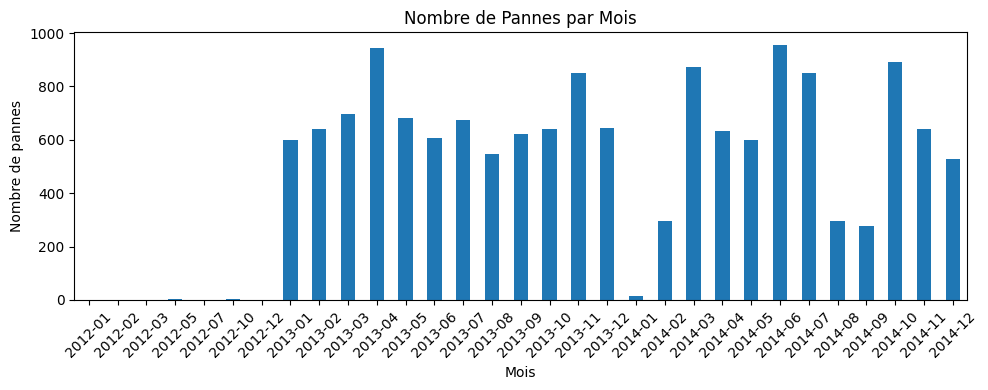

In [5]:
print("IDENTIFICATION DES PANNES")
print("=" * 50)

# Définir ce qui constitue une panne
df_clean['is_panne'] = (df_clean['TypeIntervention'] == 'incident').astype(int)

print(f"Statistiques des pannes:")
print(f"   Total interventions: {len(df_clean):,}")
print(f"   Pannes identifiées: {df_clean['is_panne'].sum():,}")
print(f"   Taux de panne: {df_clean['is_panne'].mean()*100:.1f}%")

# Visualisation
plt.figure(figsize=(10, 4))
df_clean.groupby(df_clean['DateDebut'].dt.to_period('M'))['is_panne'].sum().plot(kind='bar')
plt.title('Nombre de Pannes par Mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de pannes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cellule 6 : Calcul du Temps Entre Pannes

In [6]:
print("CALCUL DU TEMPS ENTRE PANNES")
print("=" * 50)

time_to_failure_data = []

for equipment in df_clean['code_equipement'].unique():
    eq_data = df_clean[df_clean['code_equipement'] == equipment].copy()

    # Filtrer uniquement les pannes
    pannes = eq_data[eq_data['is_panne'] == 1].copy()

    if len(pannes) >= 2:  # Au moins 2 pannes pour calculer un intervalle
        # Calculer le temps entre chaque panne
        pannes['time_to_next_failure'] = pannes['DateDebut'].diff().shift(-1).dt.days

        # Pour chaque panne (sauf la dernière)
        for idx in range(len(pannes) - 1):
            record = {
                'code_equipement': equipment,
                'equipement_type': pannes.iloc[idx]['equipement'],
                'date_panne': pannes.iloc[idx]['DateDebut'],
                'days_to_next_failure': pannes.iloc[idx]['time_to_next_failure'],
                'total_interventions_before': len(eq_data[eq_data['DateDebut'] < pannes.iloc[idx]['DateDebut']]),
                'recent_interventions_30d': len(eq_data[
                    (eq_data['DateDebut'] < pannes.iloc[idx]['DateDebut']) &
                    (eq_data['DateDebut'] >= pannes.iloc[idx]['DateDebut'] - pd.Timedelta(days=30))
                ])
            }
            time_to_failure_data.append(record)

# Créer le DataFrame
ttf_df = pd.DataFrame(time_to_failure_data)
ttf_df = ttf_df.dropna(subset=['days_to_next_failure'])

print(f"Données de temps jusqu'à la panne créées:")
print(f"   Nombre d'observations: {len(ttf_df):,}")
print(f"   Nombre d'équipements: {ttf_df['code_equipement'].nunique():,}")

# Statistiques
print(f"\nStatistiques du temps entre pannes:")
print(f"   Moyenne: {ttf_df['days_to_next_failure'].mean():.1f} jours")
print(f"   Médiane: {ttf_df['days_to_next_failure'].median():.1f} jours")
print(f"   Min: {ttf_df['days_to_next_failure'].min():.0f} jours")
print(f"   Max: {ttf_df['days_to_next_failure'].max():.0f} jours")

CALCUL DU TEMPS ENTRE PANNES
Données de temps jusqu'à la panne créées:
   Nombre d'observations: 13,435
   Nombre d'équipements: 485

Statistiques du temps entre pannes:
   Moyenne: 14.1 jours
   Médiane: 0.0 jours
   Min: 0 jours
   Max: 632 jours


### Cellule 7: Feature Engineering Temporel

In [7]:
print("FEATURE ENGINEERING TEMPOREL")
print("=" * 50)

enhanced_data = []

for equipment in df_clean['code_equipement'].unique():
    eq_data = df_clean[df_clean['code_equipement'] == equipment].copy()
    pannes = eq_data[eq_data['is_panne'] == 1].copy()

    if len(pannes) >= 2:
        for idx in range(len(pannes) - 1):
            current_date = pannes.iloc[idx]['DateDebut']
            next_failure_date = pannes.iloc[idx + 1]['DateDebut']

            # Features temporelles
            features = {
                'code_equipement': equipment,
                'equipement_type': pannes.iloc[idx]['equipement'],
                'date_actuelle': current_date,
                'days_to_next_failure': (next_failure_date - current_date).days,

                # Historique
                'age_equipment_days': (current_date - eq_data['DateDebut'].min()).days,
                'total_pannes_before': len(pannes[pannes['DateDebut'] < current_date]),
                'total_interventions_before': len(eq_data[eq_data['DateDebut'] < current_date]),

                # Activité récente
                'interventions_last_7d': len(eq_data[
                    (eq_data['DateDebut'] < current_date) &
                    (eq_data['DateDebut'] >= current_date - pd.Timedelta(days=7))
                ]),
                'interventions_last_30d': len(eq_data[
                    (eq_data['DateDebut'] < current_date) &
                    (eq_data['DateDebut'] >= current_date - pd.Timedelta(days=30))
                ]),
                'interventions_last_90d': len(eq_data[
                    (eq_data['DateDebut'] < current_date) &
                    (eq_data['DateDebut'] >= current_date - pd.Timedelta(days=90))
                ]),

                # Temps depuis la dernière intervention
                'days_since_last_intervention': (current_date - eq_data[eq_data['DateDebut'] < current_date]['DateDebut'].max()).days if len(eq_data[eq_data['DateDebut'] < current_date]) > 0 else 0,

                # Saisonnalité
                'month': current_date.month,
                'quarter': current_date.quarter,
                'day_of_week': current_date.dayofweek,
                'is_weekend': int(current_date.dayofweek >= 5)
            }

            # Calculer le taux d'intervention
            if features['age_equipment_days'] > 0:
                features['intervention_rate'] = features['total_interventions_before'] / features['age_equipment_days']
            else:
                features['intervention_rate'] = 0

            enhanced_data.append(features)

# Créer le DataFrame final
model_df = pd.DataFrame(enhanced_data)
print(f"Dataset enrichi créé: {len(model_df):,} observations")
print(f"Aperçu des features créées:")
print(model_df.head())

FEATURE ENGINEERING TEMPOREL
Dataset enrichi créé: 13,435 observations
Aperçu des features créées:
  code_equipement equipement_type       date_actuelle  days_to_next_failure  \
0       ADB000010        Database 2013-01-10 09:38:00                     0   
1       ADB000010        Database 2013-01-10 11:44:00                     0   
2       ADB000010        Database 2013-01-10 15:00:00                    32   
3       ADB000010        Database 2013-02-12 10:15:00                    58   
4       ADB000010        Database 2013-04-12 08:31:00                    29   

   age_equipment_days  total_pannes_before  total_interventions_before  \
0                   0                    0                           0   
1                   0                    1                           1   
2                   0                    2                           2   
3                  33                    3                           3   
4                  91                    4              

### Cellule 8: Analyse Exploratoire

ANALYSE EXPLORATOIRE


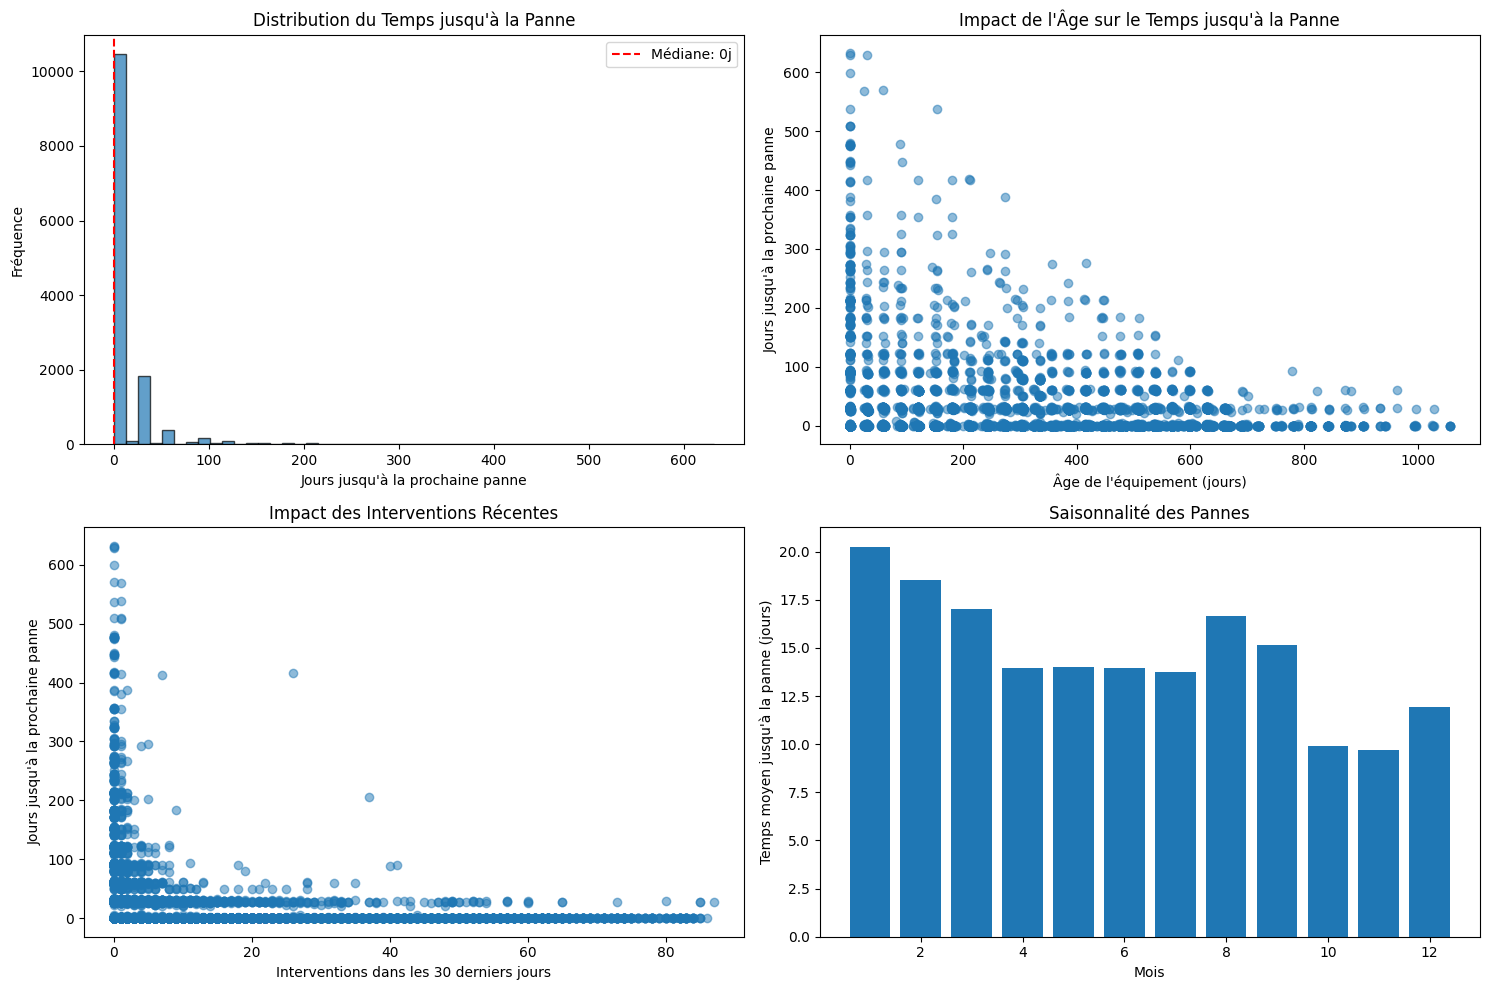

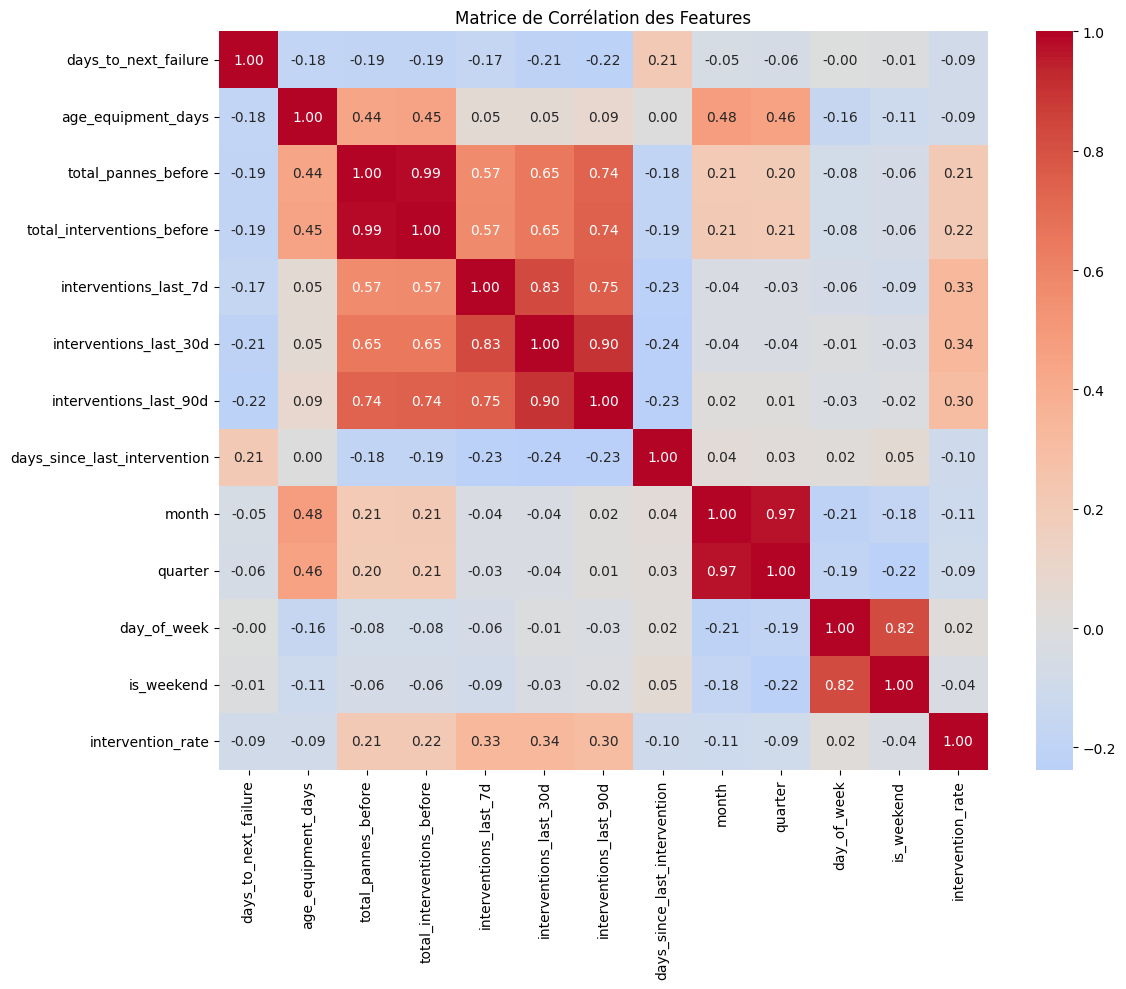

In [8]:
print("ANALYSE EXPLORATOIRE")
print("=" * 50)

# Visualisations pour comprendre les patterns temporels
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution du temps jusqu'à la panne
axes[0, 0].hist(model_df['days_to_next_failure'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Jours jusqu\'à la prochaine panne')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution du Temps jusqu\'à la Panne')
axes[0, 0].axvline(model_df['days_to_next_failure'].median(), color='red', linestyle='--',
                   label=f'Médiane: {model_df["days_to_next_failure"].median():.0f}j')
axes[0, 0].legend()

# 2. Relation avec l'âge de l'équipement
axes[0, 1].scatter(model_df['age_equipment_days'], model_df['days_to_next_failure'], alpha=0.5)
axes[0, 1].set_xlabel('Âge de l\'équipement (jours)')
axes[0, 1].set_ylabel('Jours jusqu\'à la prochaine panne')
axes[0, 1].set_title('Impact de l\'Âge sur le Temps jusqu\'à la Panne')

# 3. Impact du nombre d'interventions récentes
axes[1, 0].scatter(model_df['interventions_last_30d'], model_df['days_to_next_failure'], alpha=0.5)
axes[1, 0].set_xlabel('Interventions dans les 30 derniers jours')
axes[1, 0].set_ylabel('Jours jusqu\'à la prochaine panne')
axes[1, 0].set_title('Impact des Interventions Récentes')

# 4. Saisonnalité
monthly_avg = model_df.groupby('month')['days_to_next_failure'].mean()
axes[1, 1].bar(monthly_avg.index, monthly_avg.values)
axes[1, 1].set_xlabel('Mois')
axes[1, 1].set_ylabel('Temps moyen jusqu\'à la panne (jours)')
axes[1, 1].set_title('Saisonnalité des Pannes')

plt.tight_layout()
plt.show()

# Matrice de corrélation
numeric_cols = model_df.select_dtypes(include=[np.number]).columns
correlation_matrix = model_df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice de Corrélation des Features')
plt.tight_layout()
plt.show()

### Cellule 9: Préparation pour la Modélisation

In [9]:
print("PRÉPARATION POUR LA MODÉLISATION")
print("=" * 50)

# Sélection des features
feature_cols = [
    'age_equipment_days', 'total_pannes_before', 'total_interventions_before',
    'interventions_last_7d', 'interventions_last_30d', 'interventions_last_90d',
    'days_since_last_intervention', 'intervention_rate',
    'month', 'quarter', 'day_of_week', 'is_weekend'
]

# Encodage du type d'équipement
le = LabelEncoder()
model_df['equipement_type_encoded'] = le.fit_transform(model_df['equipement_type'])
feature_cols.append('equipement_type_encoded')

# Préparation des données
X = model_df[feature_cols]
y = model_df['days_to_next_failure']

# Division temporelle (important pour les séries temporelles)
split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Données préparées:")
print(f"   Train: {len(X_train):,} observations")
print(f"   Test: {len(X_test):,} observations")
print(f"   Features: {len(feature_cols)}")

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation appliquée")

PRÉPARATION POUR LA MODÉLISATION
Données préparées:
   Train: 10,748 observations
   Test: 2,687 observations
   Features: 13
Normalisation appliquée


### Cellule 10: Entraînement des Modèles

In [10]:
print("ENTRAÎNEMENT DES MODÈLES DE RÉGRESSION")
print("=" * 50)

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    print(f"\nEntraînement de {name}...")

    # Entraînement
    model.fit(X_train, y_train)

    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métriques
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)

    results[name] = {
        'model': model,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'rmse_test': rmse_test,
        'r2_test': r2_test,
        'predictions': y_pred_test
    }

    print(f"   MAE Train: {mae_train:.1f} jours")
    print(f"   MAE Test: {mae_test:.1f} jours")
    print(f"   RMSE Test: {rmse_test:.1f} jours")
    print(f"   R² Test: {r2_test:.3f}")

# Sélection du meilleur modèle
best_model_name = min(results.keys(), key=lambda x: results[x]['mae_test'])
best_model = results[best_model_name]['model']
print(f"\nMeilleur modèle: {best_model_name}")

ENTRAÎNEMENT DES MODÈLES DE RÉGRESSION

Entraînement de Random Forest...
   MAE Train: 7.5 jours
   MAE Test: 11.6 jours
   RMSE Test: 28.7 jours
   R² Test: 0.119

Entraînement de Gradient Boosting...
   MAE Train: 16.3 jours
   MAE Test: 9.2 jours
   RMSE Test: 26.5 jours
   R² Test: 0.250

Entraînement de XGBoost...
   MAE Train: 10.6 jours
   MAE Test: 10.6 jours
   RMSE Test: 32.2 jours
   R² Test: -0.110

Meilleur modèle: Gradient Boosting


### Cellule 11: Analyse d'Importance des Features

ANALYSE D'IMPORTANCE DES FEATURES
Top 10 Features les plus importantes:
------------------------------------------------------------
 1. total_pannes_before             43.72%
 2. interventions_last_90d          16.54%
 3. month                            9.96%
 4. equipement_type_encoded          5.96%
 5. intervention_rate                5.58%
 6. days_since_last_intervention     3.73%
 7. interventions_last_30d           3.36%
 8. age_equipment_days               2.65%
 9. total_interventions_before       2.48%
10. interventions_last_7d            1.95%


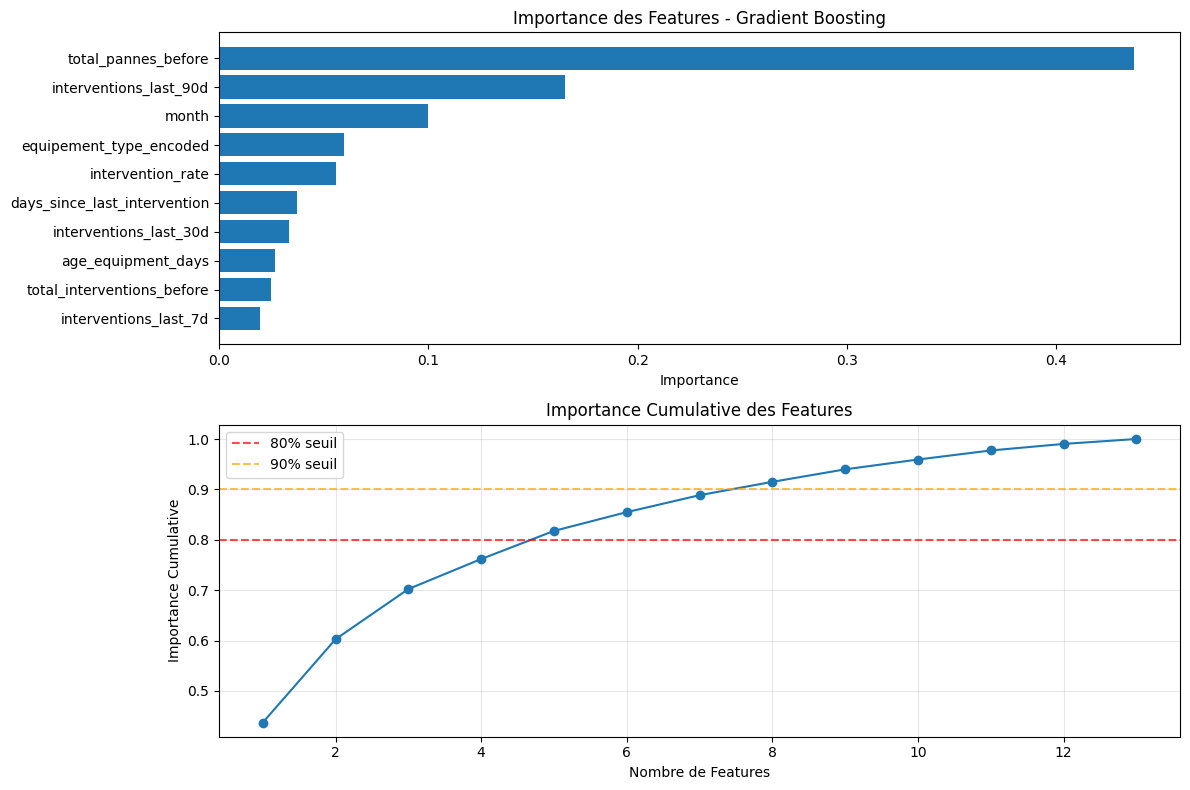

In [11]:
print("ANALYSE D'IMPORTANCE DES FEATURES")
print("=" * 50)

# Importance des features pour le meilleur modèle
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("Top 10 Features les plus importantes:")
    print("-" * 60)
    for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<30} {row['importance']*100:6.2f}%")

    # Visualisation
    plt.figure(figsize=(12, 8))

    # Graphique en barres
    plt.subplot(2, 1, 1)
    top_features = feature_importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Importance des Features - {best_model_name}')
    plt.gca().invert_yaxis()

    # Importance cumulative
    plt.subplot(2, 1, 2)
    cumulative_importance = feature_importance_df['importance'].cumsum()
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o')
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% seuil')
    plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% seuil')
    plt.xlabel('Nombre de Features')
    plt.ylabel('Importance Cumulative')
    plt.title('Importance Cumulative des Features')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Cellule 12: Installation et Analyse de Survie

Installation de lifelines...
ANALYSE DE SURVIE (KAPLAN-MEIER)


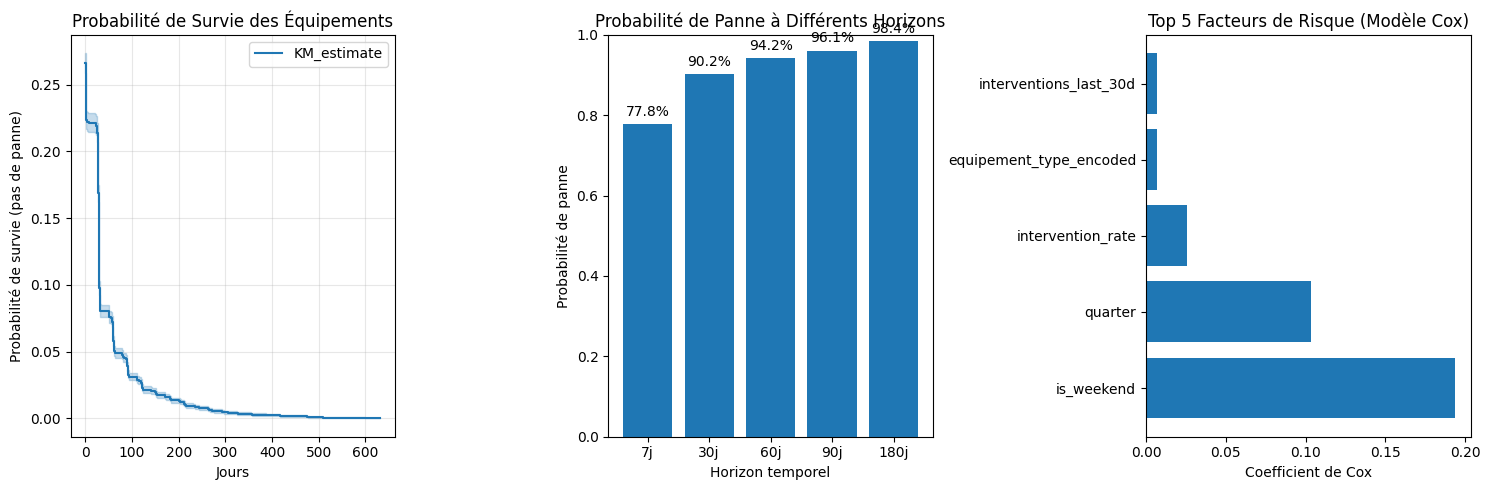

Temps médian jusqu'à la panne: 0 jours
Concordance Index (Cox): 0.746


In [12]:
# Installation de lifelines si nécessaire
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    print("Lifelines déjà installé")
except ImportError:
    print("Installation de lifelines...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lifelines"])
    from lifelines import KaplanMeierFitter, CoxPHFitter

print("ANALYSE DE SURVIE (KAPLAN-MEIER)")
print("=" * 50)

# Préparation des données pour l'analyse de survie
survival_data = model_df[['code_equipement', 'days_to_next_failure']].copy()
survival_data['event_observed'] = 1  # Toutes les pannes sont observées

# Créer l'estimateur Kaplan-Meier global
kmf = KaplanMeierFitter()
kmf.fit(survival_data['days_to_next_failure'], survival_data['event_observed'])

# Visualisation
plt.figure(figsize=(15, 5))

# Courbe de survie globale
plt.subplot(1, 3, 1)
kmf.plot_survival_function()
plt.title('Probabilité de Survie des Équipements')
plt.xlabel('Jours')
plt.ylabel('Probabilité de survie (pas de panne)')
plt.grid(True, alpha=0.3)

# Probabilités à des temps spécifiques
plt.subplot(1, 3, 2)
time_points = [7, 30, 60, 90, 180]
probabilities = []
for t in time_points:
    if t <= kmf.survival_function_.index.max():
        prob = kmf.survival_function_at_times(t).values[0]
        probabilities.append(1 - prob)  # Probabilité de panne
    else:
        probabilities.append(1.0)

plt.bar([f'{t}j' for t in time_points], probabilities)
plt.title('Probabilité de Panne à Différents Horizons')
plt.xlabel('Horizon temporel')
plt.ylabel('Probabilité de panne')
plt.ylim(0, 1)
for i, (t, p) in enumerate(zip(time_points, probabilities)):
    plt.text(i, p + 0.02, f'{p:.1%}', ha='center')

# Modèle de Cox
plt.subplot(1, 3, 3)
cox_data = model_df[feature_cols + ['days_to_next_failure']].copy()
cox_data['event_observed'] = 1

cph = CoxPHFitter()
cph.fit(cox_data, duration_col='days_to_next_failure', event_col='event_observed')

# Afficher les coefficients les plus significatifs
top_coefs = cph.summary.nlargest(5, 'coef')['coef']
plt.barh(range(len(top_coefs)), top_coefs.values)
plt.yticks(range(len(top_coefs)), top_coefs.index)
plt.xlabel('Coefficient de Cox')
plt.title('Top 5 Facteurs de Risque (Modèle Cox)')

plt.tight_layout()
plt.show()

# Temps médian jusqu'à la panne
median_time = kmf.median_survival_time_
print(f"Temps médian jusqu'à la panne: {median_time:.0f} jours")
print(f"Concordance Index (Cox): {cph.concordance_index_:.3f}")

### Cellule 13: Fonction de Prédiction


In [13]:
def predict_time_to_failure(equipment_code, current_date=None):
    """
    Prédit quand un équipement va tomber en panne

    Args:
        equipment_code: Code de l'équipement
        current_date: Date actuelle (par défaut: aujourd'hui)

    Returns:
        dict: Prédictions détaillées
    """
    if current_date is None:
        current_date = pd.Timestamp.now()
    else:
        current_date = pd.to_datetime(current_date)

    # Récupérer l'historique de l'équipement
    eq_history = df_clean[df_clean['code_equipement'] == equipment_code].copy()
    if len(eq_history) == 0:
        return {'error': 'Équipement non trouvé'}

    # Calculer les features
    features = {
        'age_equipment_days': (current_date - eq_history['DateDebut'].min()).days,
        'total_pannes_before': len(eq_history[(eq_history['is_panne'] == 1) & (eq_history['DateDebut'] < current_date)]),
        'total_interventions_before': len(eq_history[eq_history['DateDebut'] < current_date]),
        'interventions_last_7d': len(eq_history[
            (eq_history['DateDebut'] < current_date) &
            (eq_history['DateDebut'] >= current_date - pd.Timedelta(days=7))
        ]),
        'interventions_last_30d': len(eq_history[
            (eq_history['DateDebut'] < current_date) &
            (eq_history['DateDebut'] >= current_date - pd.Timedelta(days=30))
        ]),
        'interventions_last_90d': len(eq_history[
            (eq_history['DateDebut'] < current_date) &
            (eq_history['DateDebut'] >= current_date - pd.Timedelta(days=90))
        ]),
        'days_since_last_intervention': (current_date - eq_history[eq_history['DateDebut'] < current_date]['DateDebut'].max()).days if len(eq_history[eq_history['DateDebut'] < current_date]) > 0 else 0,
        'month': current_date.month,
        'quarter': current_date.quarter,
        'day_of_week': current_date.dayofweek,
        'is_weekend': int(current_date.dayofweek >= 5),
        'equipement_type_encoded': le.transform([eq_history['equipement'].iloc[0]])[0]
    }

    # Calculer le taux d'intervention
    if features['age_equipment_days'] > 0:
        features['intervention_rate'] = features['total_interventions_before'] / features['age_equipment_days']
    else:
        features['intervention_rate'] = 0

    # Créer le DataFrame pour la prédiction
    X_pred = pd.DataFrame([features])[feature_cols]

    # Prédiction avec le modèle de régression
    days_to_failure = best_model.predict(X_pred)[0]
    predicted_date = current_date + pd.Timedelta(days=int(days_to_failure))

    # Calculer les probabilités à différents horizons avec Kaplan-Meier
    probabilities = {}
    for horizon in [7, 30, 90]:
        if horizon <= kmf.survival_function_.index.max():
            survival_prob = kmf.survival_function_at_times(horizon).values[0]
            probabilities[f'{horizon}_days'] = 1 - survival_prob

    # Déterminer le niveau de risque
    if days_to_failure <= 7:
        risk_level = "CRITIQUE"
        action = "Maintenance d'urgence requise"
    elif days_to_failure <= 30:
        risk_level = "ÉLEVÉ"
        action = "Planifier maintenance dans les 2 semaines"
    elif days_to_failure <= 90:
        risk_level = "MODÉRÉ"
        action = "Surveillance accrue recommandée"
    else:
        risk_level = "FAIBLE"
        action = "Maintenance préventive standard"

    return {
        'equipment_code': equipment_code,
        'current_date': current_date.strftime('%Y-%m-%d'),
        'predicted_failure_date': predicted_date.strftime('%Y-%m-%d'),
        'days_to_failure': int(days_to_failure),
        'risk_level': risk_level,
        'recommended_action': action,
        'failure_probabilities': probabilities,
        'confidence_interval': {
            'lower': max(0, int(days_to_failure * 0.7)),
            'upper': int(days_to_failure * 1.3)
        }
    }

print("Fonction de prédiction créée avec succès")

Fonction de prédiction créée avec succès


### Cellule 14: Interface de Prédiction Interactive

Test de la fonction de prédiction:

Résultat de prédiction:
equipment_code: ADB000010
current_date: 2025-08-04
predicted_failure_date: 2026-01-14
days_to_failure: 163
risk_level: FAIBLE
recommended_action: Maintenance préventive standard
failure_probabilities:
  - 7_days: 77.8%
  - 30_days: 90.2%
  - 90_days: 96.1%
confidence_interval: {'lower': 114, 'upper': 212}
SYSTÈME DE PRÉDICTION TEMPORELLE DE PANNE

Prédictions pour 5 équipements échantillons:
----------------------------------------------------------------------------------------------------
Équipement      Type                      Jours avant panne    Date prévue     Risque         
----------------------------------------------------------------------------------------------------
ADB000010       Database                  163                  2026-01-14      FAIBLE         
ADB000042       Database                  59                   2025-10-02      MODÉRÉ         
ADB000050       Database                  172             

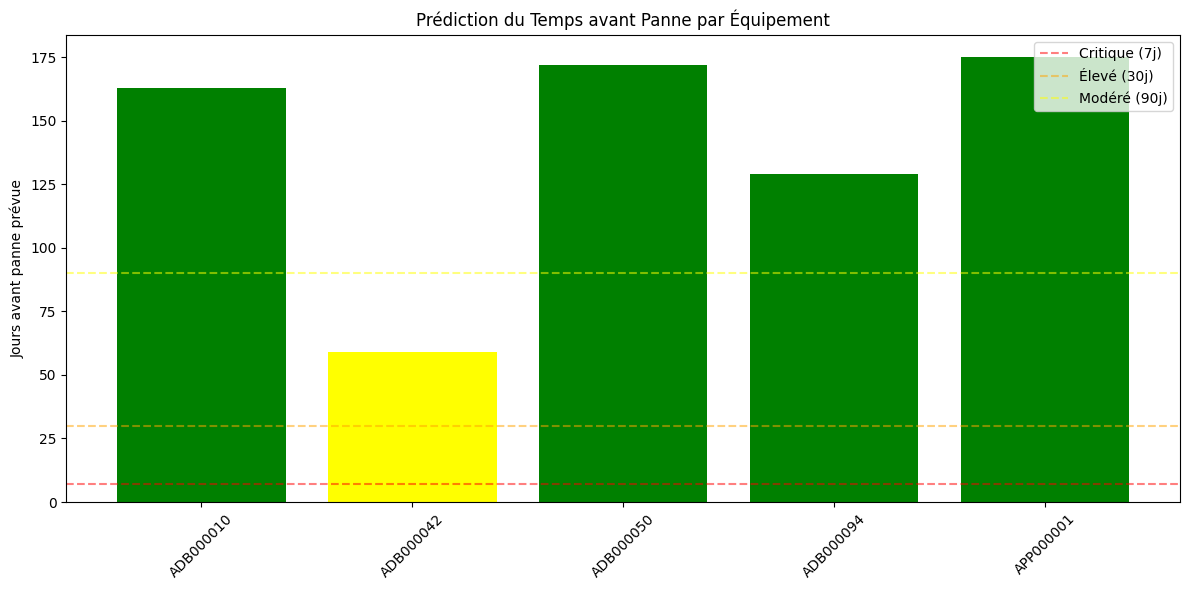

In [14]:
def interactive_failure_prediction(n_equipments=5):
    """Interface interactive pour prédire les pannes"""
    print("SYSTÈME DE PRÉDICTION TEMPORELLE DE PANNE")
    print("=" * 60)

    # Exemple avec plusieurs équipements
    sample_equipments = model_df['code_equipement'].unique()[:n_equipments]

    print(f"\nPrédictions pour {n_equipments} équipements échantillons:")
    print("-" * 100)
    print(f"{'Équipement':<15} {'Type':<25} {'Jours avant panne':<20} {'Date prévue':<15} {'Risque':<15}")
    print("-" * 100)

    predictions_list = []

    for eq_code in sample_equipments:
        pred = predict_time_to_failure(eq_code)
        if 'error' not in pred:
            eq_type = df_clean[df_clean['code_equipement'] == eq_code]['equipement'].iloc[0]
            predictions_list.append(pred)
            print(f"{eq_code:<15} {eq_type[:25]:<25} {pred['days_to_failure']:<20} {pred['predicted_failure_date']:<15} {pred['risk_level']:<15}")

    # Visualisation simple avec matplotlib
    if predictions_list:
        plt.figure(figsize=(12, 6))

        # Graphique en barres des jours avant panne
        equipment_codes = [p['equipment_code'] for p in predictions_list]
        days_to_failure = [p['days_to_failure'] for p in predictions_list]

        colors = []
        for d in days_to_failure:
            if d <= 7:
                colors.append('red')
            elif d <= 30:
                colors.append('orange')
            elif d <= 90:
                colors.append('yellow')
            else:
                colors.append('green')

        bars = plt.bar(range(len(equipment_codes)), days_to_failure, color=colors)
        plt.xticks(range(len(equipment_codes)), equipment_codes, rotation=45)
        plt.ylabel('Jours avant panne prévue')
        plt.title('Prédiction du Temps avant Panne par Équipement')

        # Ajouter des lignes horizontales pour les seuils critiques
        plt.axhline(y=7, color='red', linestyle='--', alpha=0.5, label='Critique (7j)')
        plt.axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='Élevé (30j)')
        plt.axhline(y=90, color='yellow', linestyle='--', alpha=0.5, label='Modéré (90j)')

        plt.legend()
        plt.tight_layout()
        plt.show()

    return predictions_list

# Test de la fonction
print("Test de la fonction de prédiction:")
test_equipment = model_df['code_equipement'].iloc[10]
prediction = predict_time_to_failure(test_equipment)

print("\nRésultat de prédiction:")
for key, value in prediction.items():
    if key != 'failure_probabilities':
        print(f"{key}: {value}")
    else:
        print("failure_probabilities:")
        for k, v in value.items():
            print(f"  - {k}: {v:.1%}")

# Exécuter l'interface interactive
predictions = interactive_failure_prediction()

### Cellule 15: Tableau de Bord de Maintenance

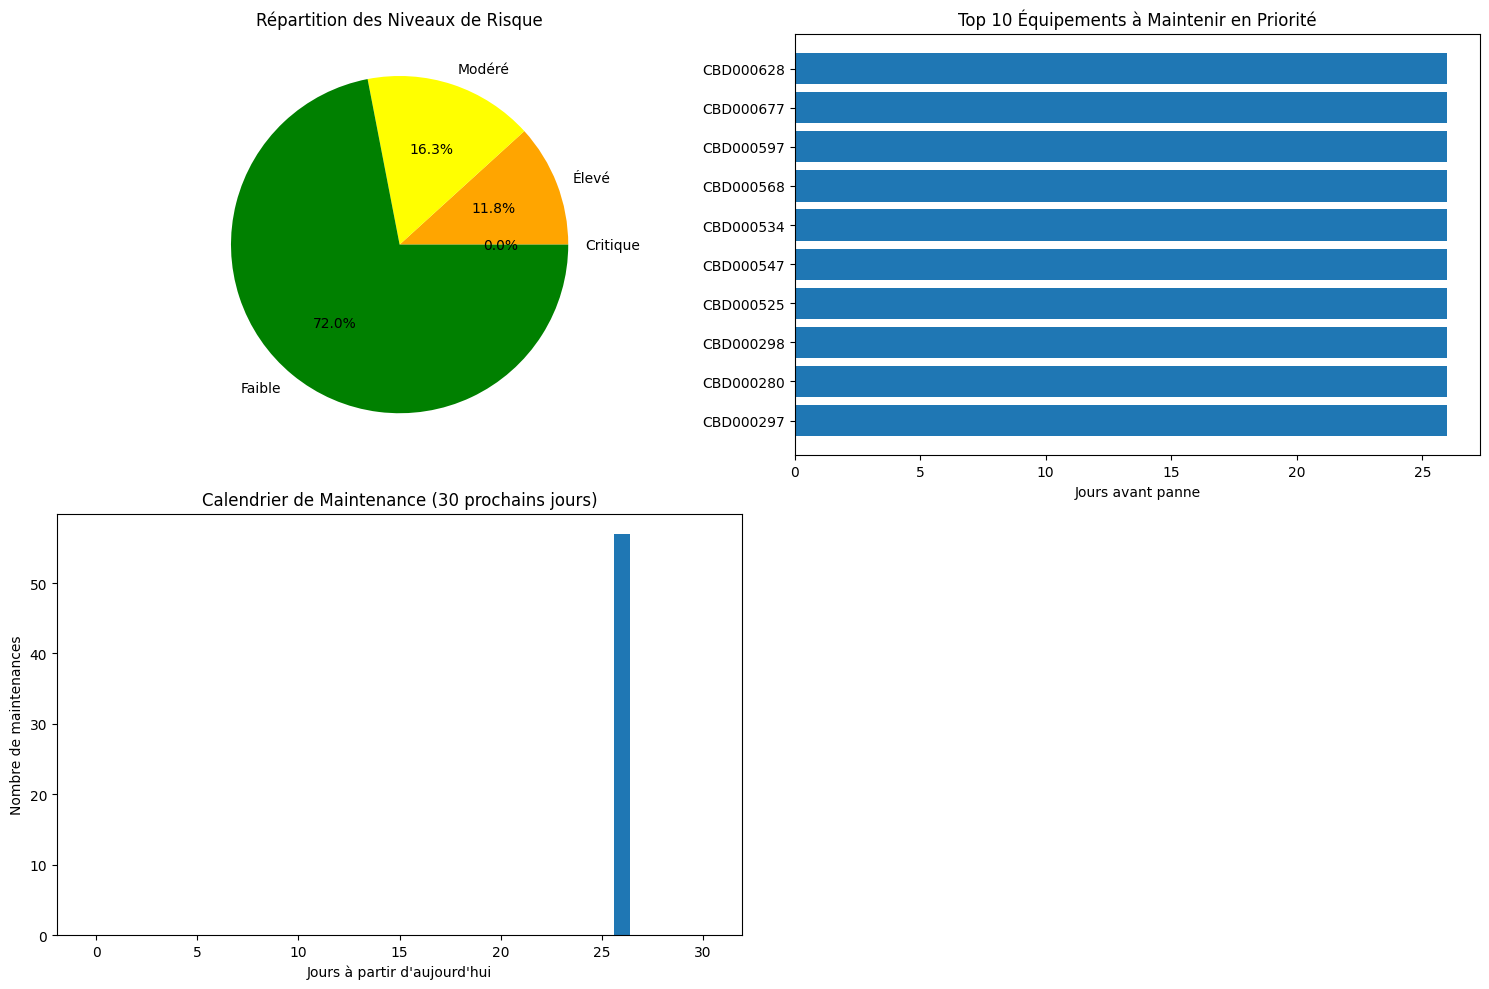

In [21]:
def create_maintenance_dashboard():
    """Crée un tableau de bord de maintenance prédictive"""
    # print("TABLEAU DE BORD DE MAINTENANCE PRÉDICTIVE")
    # print("=" * 80)

    # Analyser tous les équipements
    all_predictions = []
    for eq_code in model_df['code_equipement'].unique():
        pred = predict_time_to_failure(eq_code)
        if 'error' not in pred:
            all_predictions.append(pred)

    # Créer un DataFrame des prédictions
    pred_df = pd.DataFrame(all_predictions)

    # Statistiques globales
    # print("\nSTATISTIQUES GLOBALES")
    # print("-" * 40)
    critical = len(pred_df[pred_df['days_to_failure'] <= 7])
    high = len(pred_df[(pred_df['days_to_failure'] > 7) & (pred_df['days_to_failure'] <= 30)])
    moderate = len(pred_df[(pred_df['days_to_failure'] > 30) & (pred_df['days_to_failure'] <= 90)])
    low = len(pred_df[pred_df['days_to_failure'] > 90])

    # print(f"Critique (≤7 jours): {critical} équipements")
    # print(f"Élevé (8-30 jours): {high} équipements")
    # print(f"Modéré (31-90 jours): {moderate} équipements")
    # print(f"Faible (>90 jours): {low} équipements")

    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Distribution des risques
    risk_counts = [critical, high, moderate, low]
    risk_labels = ['Critique', 'Élevé', 'Modéré', 'Faible']
    colors = ['red', 'orange', 'yellow', 'green']
    axes[0, 0].pie(risk_counts, labels=risk_labels, colors=colors, autopct='%1.1f%%')
    axes[0, 0].set_title('Répartition des Niveaux de Risque')

    # 2. Timeline des maintenances prévues
    pred_df_sorted = pred_df.sort_values('days_to_failure').head(10)
    axes[0, 1].barh(range(len(pred_df_sorted)), pred_df_sorted['days_to_failure'])
    axes[0, 1].set_yticks(range(len(pred_df_sorted)))
    axes[0, 1].set_yticklabels(pred_df_sorted['equipment_code'])
    axes[0, 1].set_xlabel('Jours avant panne')
    axes[0, 1].set_title('Top 10 Équipements à Maintenir en Priorité')

    # 3. Calendrier de maintenance (30 prochains jours)
    next_30_days = pred_df[pred_df['days_to_failure'] <= 30].copy()
    if len(next_30_days) > 0:
        days_array = np.arange(0, 31)
        maintenance_count = [len(next_30_days[next_30_days['days_to_failure'] == d]) for d in days_array]
        axes[1, 0].bar(days_array, maintenance_count)
        axes[1, 0].set_xlabel('Jours à partir d\'aujourd\'hui')
        axes[1, 0].set_ylabel('Nombre de maintenances')
        axes[1, 0].set_title('Calendrier de Maintenance (30 prochains jours)')
    else:
        axes[1, 0].text(0.5, 0.5, 'Aucune maintenance\nprévue dans les 30 jours',
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Calendrier de Maintenance (30 prochains jours)')

    # 4. Coût estimé de maintenance
    # cost_per_risk = {'CRITIQUE': 5000, 'ÉLEVÉ': 3000, 'MODÉRÉ': 1500, 'FAIBLE': 500}
    # # Compter par niveau de risque réel
    # risk_counts_dict = pred_df['risk_level'].value_counts().to_dict()
    # total_cost = sum(risk_counts_dict.get(risk, 0) * cost for risk, cost in cost_per_risk.items())

    # axes[1, 1].text(0.1, 0.8, f"Coût Total Estimé:", fontsize=16, weight='bold',
    #                transform=axes[1, 1].transAxes)
    # axes[1, 1].text(0.1, 0.6, f"{total_cost:,.0f} MAD", fontsize=24, color='darkblue',
    #                transform=axes[1, 1].transAxes)

    # y_pos = 0.4
    # for risk, cost_per_unit in cost_per_risk.items():
    #     count = risk_counts_dict.get(risk, 0)
    #     total_risk_cost = count * cost_per_unit
    #     axes[1, 1].text(0.1, y_pos, f"{risk}: {total_risk_cost:,} MAD", fontsize=12,
    #                    transform=axes[1, 1].transAxes)
    #     y_pos -= 0.08

    axes[1, 1].axis('off')
    # axes[1, 1].set_title('Budget de Maintenance Préventive')

    plt.tight_layout()
    plt.show()

    return pred_df

# Créer le tableau de bord
dashboard_df = create_maintenance_dashboard()

### Cellule 16 : Export et Sauvegarde

In [22]:
print("SAUVEGARDE DU MODÈLE TEMPOREL")
print("=" * 50)

# Création du package du modèle
temporal_model_package = {
    'regression_model': best_model,
    'model_name': best_model_name,
    'feature_columns': feature_cols,
    'label_encoder': le,
    'scaler': scaler,
    'performance_metrics': {
        'mae': results[best_model_name]['mae_test'],
        'rmse': results[best_model_name]['rmse_test'],
        'r2': results[best_model_name]['r2_test']
    },
    'training_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'n_samples_train': len(X_train),
        'n_samples_test': len(X_test),
        'median_time_to_failure': y_train.median()
    },
    'metadata': {
        'version': '1.0',
        'author': 'Aymane ISSAMI',
        'description': "Pipeline complet de Machine Learning pour prédire le moment probable de défaillance d'un équipement",
        'objective': "Prédiction de maintenance"
    }
}

# Ajouter le modèle de survie si disponible
if 'kmf' in globals():
    temporal_model_package['survival_model'] = {
        'median_survival_time': kmf.median_survival_time_,
        'survival_function_times': kmf.survival_function_.index.tolist(),
        'survival_function_values': kmf.survival_function_.values.flatten().tolist()
    }

# Sauvegarde du modèle
filename = f'model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(temporal_model_package, filename)
print(f"Modèle sauvegardé: {filename}")

# Export des prédictions
if 'dashboard_df' in globals():
    csv_filename = f'predictions_notebook_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    dashboard_df.to_csv(csv_filename, index=False)
    print(f"Prédictions exportées: {csv_filename}")

SAUVEGARDE DU MODÈLE TEMPOREL
Modèle sauvegardé: model_20250804_100408.pkl
Prédictions exportées: predictions_notebook_20250804_100408.csv
